Trong v2 này, sử dụng tất cả các features so với v1 để so sánh hiệu suất có bị giảm khi dùng các đặc trưng không có đóng góp thông tin

In [1]:
# Import các thư viện cần thiết
import numpy as np  # Thư viện tính toán số học
import pandas as pd  # Thư viện xử lý dữ liệu dạng bảng
import torch  # Framework deep learning PyTorch
import torch.nn as nn  # Module neural network của PyTorch
from torch.utils.data import DataLoader, Dataset  # Các công cụ load và xử lý dữ liệu của PyTorch
from sklearn.preprocessing import MinMaxScaler  # Công cụ chuẩn hóa dữ liệu
from sklearn.model_selection import train_test_split  # Công cụ chia tập train/test

# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

# Thư viện vẽ đồ thị
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị cơ bản
import seaborn as sns  # Thư viện vẽ đồ thị nâng cao

## Định nghĩa dataloader

In [2]:
# Ô này tạm thời bỏ qua không quan tâm nhiều
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# Trong pytorch, dữ liệu phải được đưa vào một đối tượng mà pytorch có thể tự động đọc, điều này không giống trong keras do cách
# hoạt động khác nhau của mỗi framework
# FD001Dataset sẽ là nơi làm việc này, và trong này cũng miêu tả cách dữ liệu được xử lý như thế nào luôn

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD001Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        # Khởi tạo dataset với data là DataFrame và độ dài chuỗi mặc định là 30
        self.data = data # DataFrame chứa dữ liệu đầu vào
        self.sequence_length = sequence_length # Độ dài chuỗi thời gian để dự đoán
        self.sequences = [] # Lưu các chuỗi dữ liệu đầu vào
        self.targets = [] # Lưu các giá trị RUL cần dự đoán
        
        # Nhóm dữ liệu theo ID động cơ
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            # Lấy các đặc trưng, bỏ các cột không cần thiết
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            # Lấy cột RUL làm nhãn
            rul_values = group['Remaining RUL'].values
            
            # Tạo các chuỗi con có độ dài sequence_length
            for i in range(len(values) - sequence_length + 1):
                # Thêm chuỗi dữ liệu vào sequences
                self.sequences.append(values[i:i + sequence_length]) 
                # Thêm giá trị RUL tương ứng vào targets
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        # Trả về số lượng mẫu trong dataset
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Trả về một cặp (dữ liệu, nhãn) tại vị trí idx
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

## Định nghĩa mô hình Transformer

In [ ]:
# Xây dựng kiến trúc mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        # Lớp embedding để chuyển đổi input thành vector có kích thước d_model
        self.input_embedding = nn.Linear(input_dim, d_model)
        # Positional encoding để mã hóa vị trí của các phần tử trong chuỗi
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        # Khối Transformer chính
        self.transformer = nn.Transformer(
            d_model=d_model,      # Kích thước của model
            nhead=nhead,          # Số lượng head trong multi-head attention
            num_encoder_layers=num_layers,    # Số lớp encoder
            num_decoder_layers=num_layers,    # Số lớp decoder
            dim_feedforward=dim_feedforward,  # Kích thước của feedforward network
            dropout=dropout,      # Tỷ lệ dropout để tránh overfitting
        )
        # Lớp fully connected cuối cùng để dự đoán
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        # Thêm positional encoding vào input embedding
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        # Chuyển đổi kích thước để phù hợp với Transformer [seq_len, batch_size, d_model]
        src_emb = src_emb.permute(1, 0, 2)
        # Đưa qua transformer
        transformer_out = self.transformer(src_emb, src_emb)
        # Lấy output cuối cùng và dự đoán
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)


## Loading dataset and preprocessing

In [5]:
train_1 = "../data/train_FD001.txt"

In [6]:
# Tạo danh sách tên cột cho DataFrame
index_names = ['ID Engine', 'Cycle']  # Tên cột chỉ mục: ID động cơ và số chu kỳ
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']  # Tên các cột cài đặt
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]  # Tạo tên cho 21 cảm biến từ 1-21
column_names = index_names + setting_names + sensor_names  # Gộp tất cả tên cột lại

# Đọc dữ liệu từ file CSV
train_1 = pd.read_csv(train_1, sep=' ', header=None)  # Đọc file với dấu phân cách là khoảng trắng
train_1.drop([26, 27], axis=1, inplace=True)  # Xóa 2 cột thừa 26 và 27
train_1.columns = column_names  # Đặt tên cho các cột

train_1['Remaining RUL'] = ''  # Thêm cột Remaining RUL với giá trị rỗng
train_1.head()  # Hiển thị 5 dòng đầu tiên của DataFrame

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,


In [7]:
# Tính toán RUL (Remaining Useful Life - Tuổi thọ còn lại) cho mỗi động cơ
# Bước 1: Tìm số chu kỳ tối đa của mỗi động cơ
max_cycle = train_1.groupby('ID Engine').count()

# Bước 2: Duyệt qua từng dòng dữ liệu
for idx in range(len(train_1)):
    # Gán số chu kỳ tối đa của động cơ tương ứng vào cột 'Remaining RUL'
    train_1.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']

# Bước 3: Tính RUL bằng cách lấy số chu kỳ tối đa trừ đi chu kỳ hiện tại
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

In [8]:
# Loại bỏ các cột không cần thiết từ tập dữ liệu train_1:
# - Các cột Setting 1, 2, 3: Loại bỏ vì là các thông số cài đặt không ảnh hưởng nhiều
# - Các cột Sensor 1, 5, 6, 10, 16, 18, 19: Loại bỏ vì là các cảm biến có tương quan thấp với RUL

# train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)

# Hiển thị 5 dòng đầu tiên của dữ liệu sau khi đã loại bỏ các cột
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
# Chuẩn hóa dữ liệu (Normalize data)
# Tạo một bản sao của tập dữ liệu train_1
df = train_1.copy()

# Lấy tất cả các cột từ cột thứ 3 trở đi (bỏ qua 2 cột đầu)
scaled_columns = df.columns[2:]

# Khởi tạo MinMaxScaler để chuẩn hóa dữ liệu về khoảng [0,1]
scaler = MinMaxScaler()

# Chuẩn hóa dữ liệu cho các cột đã chọn
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

# Hiển thị 5 dòng đầu tiên của dữ liệu sau khi chuẩn hóa
df.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,0.529086
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,0.526316
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,0.523546
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,0.520776
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,0.518006


## Huấn luyện mô hình với sequence_length = 50, 50 epochs

In [10]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=50)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [11]:
dataset.__len__()

15731

In [12]:
train_data.__len__()

12584

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.04032093047065102, Val Loss = 0.011943802275139876
Epoch 2: Train Loss = 0.017205358552628287, Val Loss = 0.011072311169383202
Epoch 3: Train Loss = 0.014126494550500726, Val Loss = 0.010089052036743273
Epoch 4: Train Loss = 0.012468039994198961, Val Loss = 0.009366465958230423
Epoch 5: Train Loss = 0.011418032658175295, Val Loss = 0.008824784652038354
Epoch 6: Train Loss = 0.010430652391742254, Val Loss = 0.009150132583924617
Epoch 7: Train Loss = 0.009178438020614804, Val Loss = 0.0068303465259948164
Epoch 8: Train Loss = 0.008076421083849358, Val Loss = 0.00604694380984651
Epoch 9: Train Loss = 0.007244253491209867, Val Loss = 0.006297762135297738
Epoch 10: Train Loss = 0.006854021421522564, Val Loss = 0.0053973568031903014
Epoch 11: Train Loss = 0.006331676779773446, Val Loss = 0.0047482221688360275
Epoch 12: Train Loss = 0.005867193676389489, Val Loss = 0.0045168048994982555
Epoch 13: Train Loss = 0.005646696341398933, Val Loss = 0.004662498399013221
Epoch 

In [15]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.3885212242603302


In [16]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [17]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


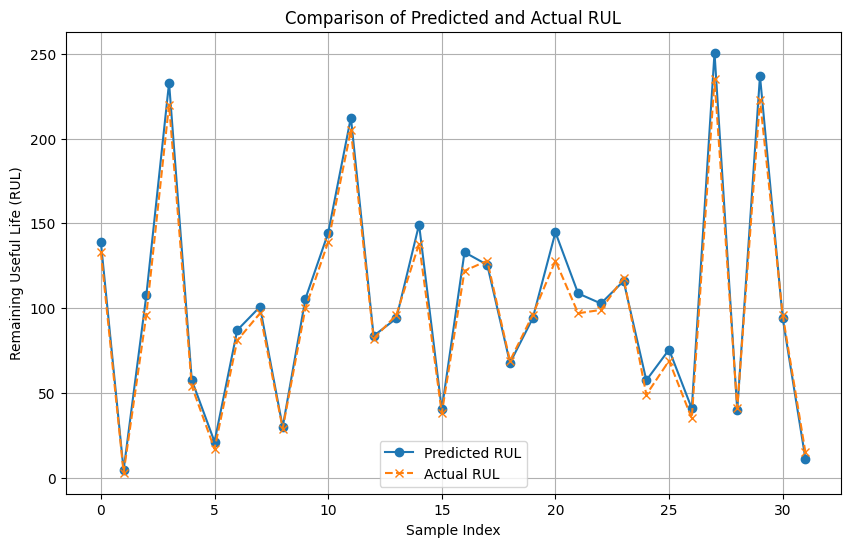

In [18]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 10, 50 epochs

In [19]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=10)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.037093845945462466, Val Loss = 0.013872380428496868
Epoch 2: Train Loss = 0.018261130445783858, Val Loss = 0.013193041919880816
Epoch 3: Train Loss = 0.015590794481570844, Val Loss = 0.013307084847662238
Epoch 4: Train Loss = 0.014580163167721708, Val Loss = 0.014633046350471916
Epoch 5: Train Loss = 0.013807286087495204, Val Loss = 0.0134652717669885
Epoch 6: Train Loss = 0.013608982432105763, Val Loss = 0.012400825203756892
Epoch 7: Train Loss = 0.01339708861842118, Val Loss = 0.012107312775051763
Epoch 8: Train Loss = 0.012961363026811949, Val Loss = 0.012580880711245681
Epoch 9: Train Loss = 0.012749997042081797, Val Loss = 0.011954109939265876
Epoch 10: Train Loss = 0.01252138840603955, Val Loss = 0.013130076890510897
Epoch 11: Train Loss = 0.012610488710736455, Val Loss = 0.01202627903248574
Epoch 12: Train Loss = 0.012417308609133306, Val Loss = 0.011876492586452514
Epoch 13: Train Loss = 0.012309291980206695, Val Loss = 0.011933543815112283
Epoch 14: Tra

In [21]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [22]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


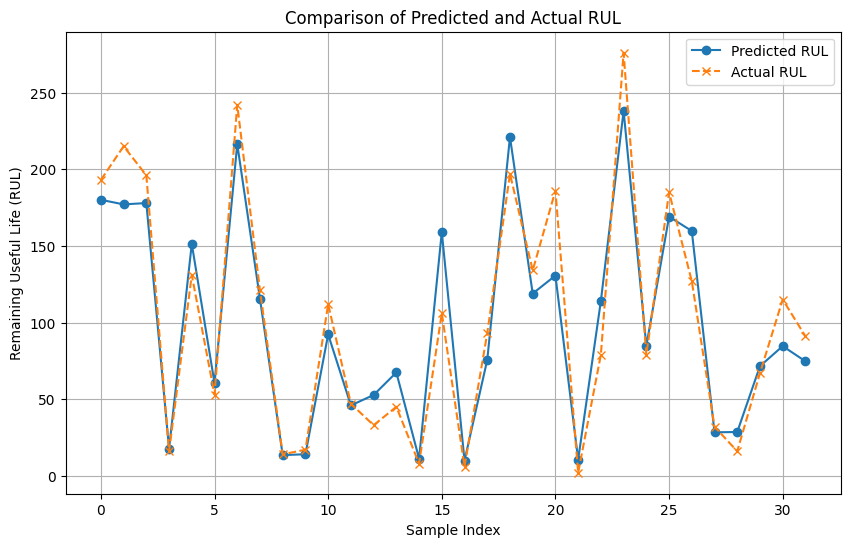

In [23]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 30, 50 epochs

In [24]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=30)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02728888586683719, Val Loss = 0.01258289959566953
Epoch 2: Train Loss = 0.01603855804733194, Val Loss = 0.011645793058984989
Epoch 3: Train Loss = 0.01368998002936342, Val Loss = 0.012004501286994767
Epoch 4: Train Loss = 0.012995492735130896, Val Loss = 0.012582854732770371
Epoch 5: Train Loss = 0.01215262461489335, Val Loss = 0.010999741133403134
Epoch 6: Train Loss = 0.011234331576610907, Val Loss = 0.010080946043033051
Epoch 7: Train Loss = 0.01045615565207963, Val Loss = 0.009034439497669269
Epoch 8: Train Loss = 0.009864043440724312, Val Loss = 0.008689405239262694
Epoch 9: Train Loss = 0.009046232088171114, Val Loss = 0.00899681934734454
Epoch 10: Train Loss = 0.008600486520056924, Val Loss = 0.008421043726942828
Epoch 11: Train Loss = 0.008345573101725496, Val Loss = 0.007260586395188495
Epoch 12: Train Loss = 0.00812651948722264, Val Loss = 0.00727105341214049
Epoch 13: Train Loss = 0.007915149800487803, Val Loss = 0.006696307714944621
Epoch 14: Train L

In [26]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [27]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


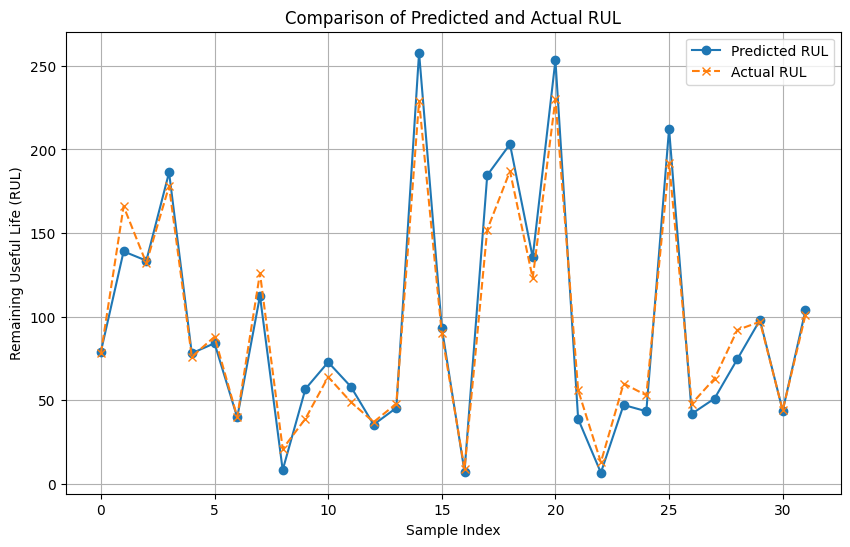

In [28]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


##

In [29]:
# import shap 
# shap.__version__

In [30]:
# samples, targets = next(iter(val_loader))
# print(samples[1].__len__())

In [31]:
# # Define a wrapper to explain the Transformer model
# class TransformerWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, inputs):
#         # Convert inputs to tensor if not already
#         if not isinstance(inputs, torch.Tensor):
#             inputs = torch.tensor(inputs, dtype=torch.float32)
#         inputs = inputs.to(device)  # Send to the same device as the model
#         with torch.no_grad():
#             outputs = self.model(inputs)
#         return outputs.cpu().numpy()

In [32]:
# # Instantiate the wrapper
# explainer_model = TransformerWrapper(model)

# sample_data = samples[0]
# sample_data = sample_data.numpy()

# # Ensure sample_data and baseline have correct dimensions
# baseline = np.mean(sample_data, axis=0, keepdims=True)  # Mean across batch
# baseline = baseline[np.newaxis, :, :]  # Add batch dimension to ensure 3D shape: [1, seq_len, feature_dim]
# print(f'baseline shape = {baseline.shape}')

# # SHAP explainer (Kernel SHAP for simplicity)
# explainer = shap.KernelExplainer(explainer_model, baseline)

# # Generate SHAP values
# shap_values = explainer.shap_values(sample_data)
# print(f'shap values = {shap_values.shape}')

In [33]:
# print(f'shap values = {shap_values.shape}')
# shap.summary_plot(shap_values, sample_data)